Implementing a CycleGAN **[50 pt]**

In this part, we will implement CycleGAN using PyTorch. We will train a model to translate images of apples to oranges and vice versa.

The CycleGAN model is composed of two generators and two discriminators. The generators are responsible for translating images from one domain to another, while the discriminators are responsible for distinguishing between translated images and real images. The generators and discriminators are trained in an adversarial manner, where the generators try to fool the discriminators and the discriminators try to distinguish between real and fake images. You can see an overview of the CycleGAN model in the figure below:
<img src="https://junyanz.github.io/CycleGAN/images/cyclegan_blogs.jpg">

You can refer to the [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) for more information.

You can first retrieve the data by executing the following cells:

In [ ]:
!wget https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true

--2025-01-23 12:13:15--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/refs/heads/master/datasets/download_cyclegan_dataset.sh [following]
--2025-01-23 12:13:15--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/refs/heads/master/datasets/download_cyclegan_dataset.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/refs/heads/master/datasets/download_cyclegan_dataset.sh [following]
--2025-01-23 12:13:16--  https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/refs/heads/master/datasets/download_cyclegan_dataset.sh
Resolving raw

In [ ]:
!mkdir datasets
!bash ./download_cyclegan_dataset.sh?raw=true apple2orange

Specified [apple2orange]
for details.

--2025-01-23 12:13:21--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./datasets/apple2orange.zip’

./datasets/apple2or 100%[===================>]  74.82M  4.54MB/s    in 18s     

2025-01-23 12:13:40 (4.06 MB/s) - ‘./datasets/apple2orange.zip’ saved [78456409/78456409]

Archive:  ./datasets/apple2orange.zip
   creating: ./datasets/apple2orange/trainA/
  inflating: ./datasets/apple2orange/trainA/n07740461_6908.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_7635.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_586.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_9813.jpg  
  inflating: ./datasets/apple2o

### 1) Dataset creation

In [ ]:
import os
import gc
import random
import torch
import torch.utils.data as data
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
from torch.optim import lr_scheduler
from IPython.display import clear_output
from torch.utils.data import Subset

Some useful functions that we will use later:

In [ ]:
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

3.1.1. You will now implement a simple dataset class in order to load the images. The dataset class should load the images from the dataset folder and apply the input transformations

In [ ]:
class GeneratorDataset(data.Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.image_path = sorted(os.listdir(root_dir))
        self.filenames = np.array(self.image_path)


    def __len__(self):

        return len(self.image_path)



    def __getitem__(self, idx):

        img_path = os.path.join(self.root_dir, self.image_path[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image)

        return image


We will now create the dataset objects for the training and testing sets:

In [ ]:
DATASET = 'apple2orange'
DATASET_PATH = os.path.join("datasets", DATASET) # Dataset path
OUTPUT_PATH = 'outputs'
base_logdir = os.path.join("logs", 'pytorch') # Sets up a log directory.
RESIZE_SHAPE = 128 # Resized image size for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataset objects
preprocess_train_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

preprocess_test_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainA"),
                           transform=preprocess_train_transformations)

train_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainB"),
                           transform=preprocess_train_transformations)

test_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testA"),
                           transform=preprocess_test_transformations)

test_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testB"),
                           transform=preprocess_test_transformations)

print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 995 images in trainA
Found 1019 images in trainB
Found 266 images in testA
Found 248 images in testB


In order to speed up the training process, we will use a subset of the training data:

In [ ]:
random.seed(42)

N_IMAGES_TO_SAMPLE = 400

indices_X = random.sample(range(len(train_data_X)), N_IMAGES_TO_SAMPLE)
indices_Y = random.sample(range(len(train_data_Y)), N_IMAGES_TO_SAMPLE)

train_data_X = Subset(train_data_X, indices_X)
train_data_Y = Subset(train_data_Y, indices_Y)

### 2) Generator and Discriminator Models

3.2.1) We will now implement the backbone for the generator and the discriminator.

In [ ]:
##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):

        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.Dropout(0.5)
        )



    def forward(self, x):

        return x + self.block(x)




class GeneratorResNet(nn.Module):
    def __init__(self, input_channel, n_blocks, filters, output_channel):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(input_channel),
            nn.Conv2d(input_channel, filters, 7),
            nn.InstanceNorm2d(filters),
            nn.ReLU(inplace=True),
        ]
        in_features = filters

        # Downsampling
        for _ in range(2):
            filters *= 2
            model += [
                nn.Conv2d(in_features, filters, 3, stride=2, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResidualBlock(filters)]

        # Upsampling
        for _ in range(2):
            filters //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, filters, 3, stride=1, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Output layer
        model += [nn.ReflectionPad2d(output_channel), nn.Conv2d(filters, output_channel, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_channel, filters):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channel, filters, normalize=False),
            *discriminator_block(filters, filters * 2),
            *discriminator_block(filters * 2, filters * 4),
            *discriminator_block(filters * 4, filters *8),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(filters *8, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

We will now instantiate the generator and discriminator models:

In [ ]:
G_XtoY = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
G_YtoX = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)

In [ ]:
Dx = Discriminator(input_channel=3, filters=64).to(device)
Dy = Discriminator(input_channel=3, filters=64).to(device)

3.2.2) You will now implement a function to randomly initialize the weights for all the convolutional layers in the generators and the discriminators with values sampled from a normal distribution (mean=0.0, std=0.02), and initialize their bias to 0.0.

In [ ]:
def weights_init_normal(m):

    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
      nn.init.normal_(m.weight.data, mean = 0.0, std = 0.02)
      if m.bias is not None:
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("InstanceNorm") != -1:
      if hasattr(m, 'weight') and m.weight is not None:
        nn.init.normal_(m.weight.data, mean = 1.0, std = 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)


# ============================
# Initialize the values of the models
# ============================
# Initialize the values of the two generators

G_XtoY.apply(weights_init_normal)
G_YtoX.apply(weights_init_normal)

# Initialize the values of the two discriminators

Dx.apply(weights_init_normal)
Dy.apply(weights_init_normal)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### 3) Training

We will define the hyperparameters used for training our CycleGAN model. The model should run on the T4 GPU provided by Google Colab. You may need to adjust the batch size to fit the model on other GPUs:

In [ ]:
BATCH_SIZE = 10
EPOCHs = 30
SAVE_EVERY_N_EPOCH = 5
LR = 0.0002
BETAS = (0.5, 0.999)

We will now define the data loaders for the training and testing sets:

In [ ]:
train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=BATCH_SIZE,
                                                    shuffle=True, num_workers=0)
train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

We will now extract some images from the test set to visualize the model's performance during training:

In [ ]:
id_sample_X = np.where(test_data_X.filenames == "n07740461_11391.jpg")[0][0]
id_sample_Y = np.where(test_data_Y.filenames == "n07749192_10081.jpg")[0][0]

sample_X = test_data_X[id_sample_X]
sample_Y = test_data_Y[id_sample_Y]

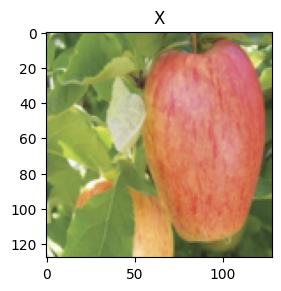

In [ ]:
plt.subplot(121)
plt.title('X')
plt.imshow(deprocess(sample_X))

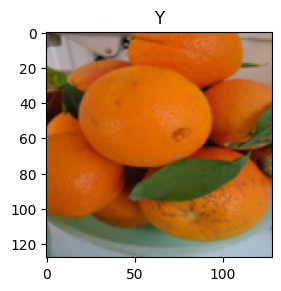

In [ ]:
plt.subplot(121)
plt.title('Y')
plt.imshow(deprocess(sample_Y))

3.3.1. Define the optimizers and schedulers for the generator and discriminator models

In [ ]:


G_XtoY_optimizer = torch.optim.Adam(G_XtoY.parameters(), lr = LR, betas = BETAS)
G_YtoX_optimizer = torch.optim.Adam(G_YtoX.parameters(), lr = LR, betas = BETAS)
Dx_optimizer = torch.optim.Adam(Dx.parameters(), lr = LR, betas = BETAS)
Dy_optimizer = torch.optim.Adam(Dy.parameters(), lr = LR, betas = BETAS)

def lambda_lr(epoch):
  decay_start_epoch = EPOCHs // 2 #to start the decay after half of the epochs
  if epoch < decay_start_epoch:
    return 1.0
  return 1.0 - (epoch - decay_start_epoch)/ (EPOCHs - decay_start_epoch)

scheduler_G_XtoY = torch.optim.lr_scheduler.LambdaLR(G_XtoY_optimizer, lr_lambda=lambda_lr)
scheduler_G_YtoX = torch.optim.lr_scheduler.LambdaLR(G_YtoX_optimizer, lr_lambda=lambda_lr)
scheduler_Dx = torch.optim.lr_scheduler.LambdaLR(Dx_optimizer, lr_lambda=lambda_lr)
scheduler_Dy = torch.optim.lr_scheduler.LambdaLR(Dy_optimizer, lr_lambda=lambda_lr)


We will now implement the different loss functions used in CycleGANs:

In [ ]:
SOFT_FAKE_LABEL_RANGE =  [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.

The discriminator loss is defined by:
\begin{equation}
\mathcal{L}_{D} = \frac{1}{2} (\mathbb{E}_{y \sim p_{data}(y)}[(D_Y(y) - r_2)^2] + \mathbb{E}_{x \sim p_{data}(x)}[(D_Y(G_{XY}(x))-r_1)^2]) + \frac{1}{2} (\mathbb{E}_{x \sim p_{data}(x)}[(D_X(x) - r_2)^2] + \mathbb{E}_{y \sim p_{data}(y)}[(D_X(G_{YX}(y))-r_1)^2])
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_1$ and $r_2$ being the soft fake and real labels chosen from a uniform distribution within the ranges $[0.0, 0.3]$ and $[0.7, 1.2]$ respectively.

3.3.2. Implement the discriminator loss function

In [ ]:
def discriminator_loss(real_pred, fake_pred):

    real_labels = torch.FloatTensor(real_pred.size()).uniform_(*SOFT_REAL_LABEL_RANGE).to(real_pred.device)
    fake_labels = torch.FloatTensor(fake_pred.size()).uniform_(*SOFT_FAKE_LABEL_RANGE).to(fake_pred.device)

    real_loss = 0.5 * torch.mean((real_pred - real_labels) ** 2)
    fake_loss = 0.5 * torch.mean((fake_pred - fake_labels) ** 2)
    loss =  real_loss + fake_loss


    return loss

The generator loss is defined by:
\begin{equation}
\mathcal{L}_{G} = \mathbb{E}_{x \sim p_{data}(x)}(D_Y(G_{XY}(x)) - r_2)^2 + \mathbb{E}_{y \sim p_{data}(y)}(D_X(G_{YX}(y)) - r_2)^2
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_2$ being the soft real label chosen from a uniform distribution within the range $[0.7, 1.2]$.

3.2.3. Implement the generator loss function for a domain

In [ ]:
def generator_loss(fake_pred):

    real_labels = torch.FloatTensor(fake_pred.size()).uniform_(*SOFT_REAL_LABEL_RANGE).to(fake_pred.device)
    loss = torch.mean((fake_pred - real_labels) ** 2)


    return loss

In addition to the traditional loss functions used in GANs, CycleGANs also use two additional loss functions: cycle consistency loss and identity loss. We will use the same $\lambda$ for the two losses.

In [ ]:
LAMBDA = 10

The cycle consistency loss is defined by:
\begin{equation}
\mathcal{L}_{cyc} = \lambda\mathbb{E}_{x \sim p_{data}(x)}[||x - G_{YX}(G_{XY}(x))||_1] + \lambda\mathbb{E}_{y \sim p_{data}(y)}[||y - G_{XY}(G_{YX}(y))||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators and $\lambda$ being the weight for the cycle consistency loss.

3.3.4. Implement the cycle consistency loss function

In [ ]:
def cycle_consistency_loss(real_image, cycled_image):

    loss = LAMBDA * torch.mean(torch.abs(real_image - cycled_image))

    return loss

The identity loss is defined by:
\begin{equation}
\mathcal{L}_{id} = \frac{1}{2}\lambda\mathbb{E}_{x \sim p_{data}(x)}[||G_{YX}(x) - x||_1] + \frac{1}{2}\lambda\mathbb{E}_{y \sim p_{data}(y)}[||G_{XY}(y) - y||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, and $\lambda$ being the weight for the identity loss.

3.3.5. Implement the identity loss function

In [ ]:
def identity_loss_function(real_image, generated_image):

    loss = 0.5 * LAMBDA * torch.mean(torch.abs(real_image - generated_image))

    return loss

The total generator loss is defined by:
\begin{equation}
\mathcal{L}_{G_{tot}} = \mathcal{L}_{G} + \mathcal{L}_{cyc} + \mathcal{L}_{id}
\end{equation}
with $\mathcal{L}_{G_X}$ and $\mathcal{L}_{G_Y}$ being the generator loss for the two domains, $\mathcal{L}_{cyc}$ being the cycle consistency loss and $\mathcal{L}_{id}$ being the identity loss.

We will now set the checkpoint path for saving the model:

In [ ]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', DATASET, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

3.3.6. Implement a function to generate in the other modality a given *test_input* image using a trained generator

In [ ]:
def generate_images(model, test_input):

    return model(test_input.to(device))


3.3.7. Perform the training process

Epoch 30/30, G_XtoY Loss: 0.4011, G_YtoX Loss: 0.3699, Dx Loss: 0.1041, Dy Loss: 0.0937


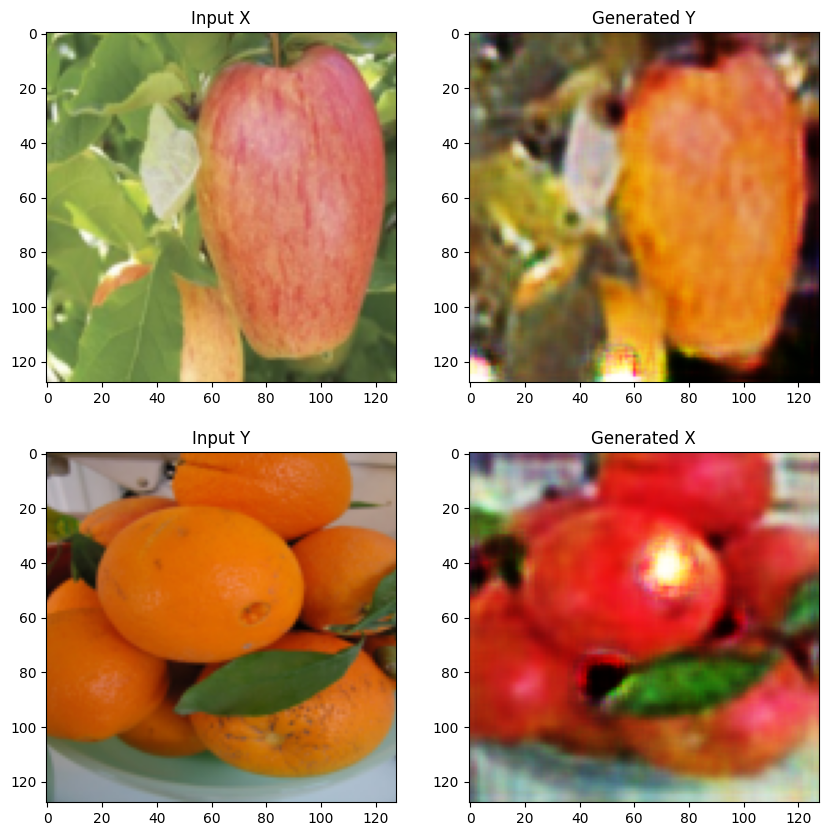

Saving checkpoint for epoch 30 at checkpoints/pytorch/apple2orange
Time taken for epoch 30 is 56.74603199958801 sec



In [ ]:
import time

training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / BATCH_SIZE)).astype(int)

for epoch in range(1, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):

        real_image_X = next(iter_train_image_X).to(device)
        real_image_Y = next(iter_train_image_Y).to(device)

        # ============================
        # Compute the discriminator loss
        # ============================
        # Generate fake images for discriminators

        fake_image_Y = generate_images(G_XtoY, real_image_X)
        fake_image_X = generate_images(G_YtoX, real_image_Y)
        Dx_real_pred = Dx(real_image_X)
        Dx_fake_pred = Dx(fake_image_X.detach())
        Dy_real_pred = Dy(real_image_Y)
        Dy_fake_pred = Dy(fake_image_Y.detach())



        # Compute the discriminator loss using the latest fake images

        Dx_loss = discriminator_loss(Dx_real_pred, Dx_fake_pred)
        Dy_loss = discriminator_loss(Dy_real_pred, Dy_fake_pred)

        # ============================
        # Update discriminators
        # ============================

        Dx_optimizer.zero_grad()
        Dx_loss.backward(retain_graph=True)  # Retain the graph for subsequent backward passes
        Dx_optimizer.step()

        Dy_optimizer.zero_grad()
        Dy_loss.backward(retain_graph=True)  # Retain the graph for subsequent backward passes
        Dy_optimizer.step()


        # Compute the generator loss using the latest fake images

        G_XtoY_loss = generator_loss(Dy(fake_image_Y))
        G_YtoX_loss = generator_loss(Dx(fake_image_X))


        # ============================
        # Compute the cycle consistency loss
        # ============================
        # Generate cycled images using the latest fake images

        cycled_image_X = generate_images(G_YtoX, fake_image_Y)
        cycled_image_Y = generate_images(G_XtoY, fake_image_X)


        # Compute the cycle consistency loss using the latest cycled images

        cycle_loss = (
            cycle_consistency_loss(real_image_X, cycled_image_X) +
            cycle_consistency_loss(real_image_Y, cycled_image_Y)
        )


        # ============================
        # Compute the identity loss
        # ============================
        # Generate identity images using the latest fake images

        identity_image_X = generate_images(G_YtoX, real_image_X)
        identity_image_Y = generate_images(G_XtoY, real_image_Y)


        # Compute the identity loss using the latest identity images

        computed_identity_loss = (
            identity_loss_function(real_image_X, identity_image_X) +
            identity_loss_function(real_image_Y, identity_image_Y)
        )


        # ============================
        # Combine all generator losses
        # ============================

        total_loss = G_XtoY_loss + G_YtoX_loss + cycle_loss + computed_identity_loss

        # ============================
        # Update generators
        # ============================

        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        total_loss.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()


        # Add losses

        G_XtoY_loss_mean += G_XtoY_loss.item()
        G_YtoX_loss_mean += G_YtoX_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()


        if step % 10 == 0:
            print ('.', end='')

    clear_output(wait=True)
    # ============================
    # Print loss values at the end of an epoch
    # ============================

    print(f"Epoch {epoch}/{EPOCHs}, G_XtoY Loss: {G_XtoY_loss_mean/training_steps:.4f}, "
      f"G_YtoX Loss: {G_YtoX_loss_mean/training_steps:.4f}, "
      f"Dx Loss: {Dx_loss_mean/training_steps:.4f}, "
      f"Dy Loss: {Dy_loss_mean/training_steps:.4f}")


    # ============================
    # Using consistent images (sample_X and sample_Y), plot the progress of the training using both generators
    # ============================

    generated_Y = generate_images(G_XtoY, sample_X.unsqueeze(0))
    generated_X = generate_images(G_YtoX, sample_Y.unsqueeze(0))

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow((sample_X.permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[0, 0].set_title("Input X")
    axs[0, 1].imshow((generated_Y.squeeze(0).detach().permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[0, 1].set_title("Generated Y")
    axs[1, 0].imshow((sample_Y.permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[1, 0].set_title("Input Y")
    axs[1, 1].imshow((generated_X.squeeze(0).detach().permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[1, 1].set_title("Generated X")
    plt.show()



    # ============================
    # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch
    # ============================
    if epoch % SAVE_EVERY_N_EPOCH == 0:

        save_training_checkpoint(epoch)

        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

    scheduler_G_XtoY.step()
    scheduler_G_YtoX.step()
    scheduler_Dx.step()
    scheduler_Dy.step()

    gc.collect()

### 4) Testing

3.4.1. Generate images using the trained models,

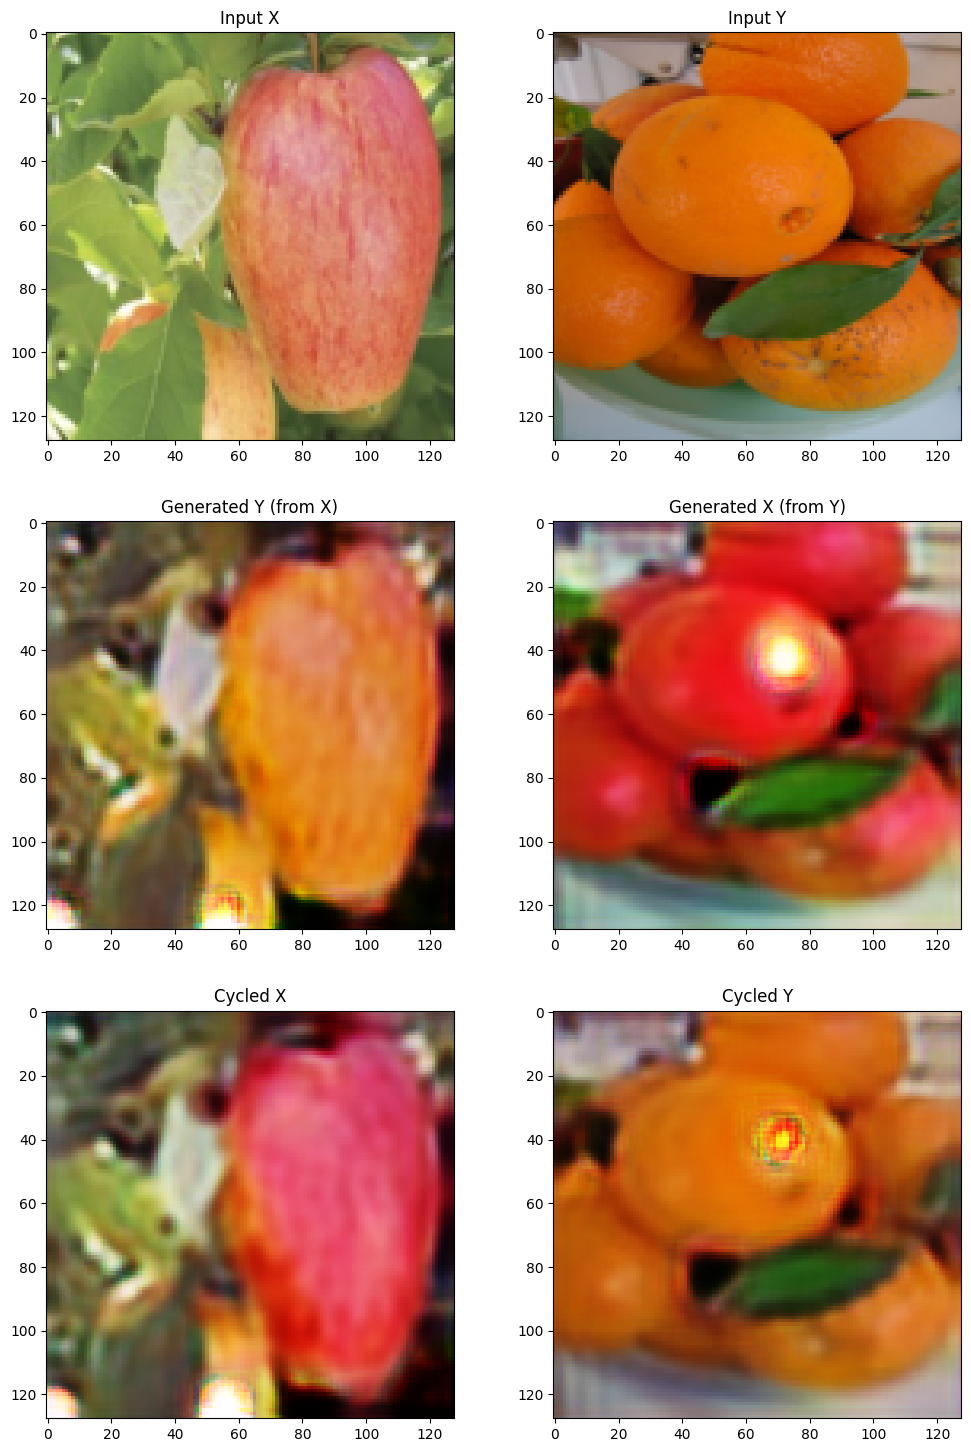

Cycle Consistency Loss (X -> Y -> X): 2.4443
Cycle Consistency Loss (Y -> X -> Y): 0.9266


In [ ]:

import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def generate_and_visualize_images(G_XtoY, G_YtoX, sample_X, sample_Y, device):
    """
    Function to generate and visualize images using trained models.
    """
    G_XtoY.eval()
    G_YtoX.eval()

    # Move sample images to device
    sample_X = sample_X.to(device)
    sample_Y = sample_Y.to(device)

    # Generate images
    with torch.no_grad():
        generated_Y = generate_images(G_XtoY, sample_X.unsqueeze(0))
        generated_X = generate_images(G_YtoX, sample_Y.unsqueeze(0))

        cycled_X = generate_images(G_YtoX, generated_Y)
        cycled_Y = generate_images(G_XtoY, generated_X)

    # Plot the results
    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    axs[0, 0].imshow(to_pil_image((sample_X + 1) / 2))
    axs[0, 0].set_title("Input X")
    axs[0, 1].imshow(to_pil_image((sample_Y + 1) / 2))
    axs[0, 1].set_title("Input Y")

    axs[1, 0].imshow(to_pil_image((generated_Y.squeeze(0) + 1) / 2))
    axs[1, 0].set_title("Generated Y (from X)")
    axs[1, 1].imshow(to_pil_image((generated_X.squeeze(0) + 1) / 2))
    axs[1, 1].set_title("Generated X (from Y)")

    axs[2, 0].imshow(to_pil_image((cycled_X.squeeze(0) + 1) / 2))
    axs[2, 0].set_title("Cycled X")
    axs[2, 1].imshow(to_pil_image((cycled_Y.squeeze(0) + 1) / 2))
    axs[2, 1].set_title("Cycled Y")

    plt.show()

# Call the function
generate_and_visualize_images(G_XtoY, G_YtoX, sample_X, sample_Y, device)

# Evaluation: Calculate and print cycle consistency loss
def evaluate_cycle_consistency_loss(G_XtoY, G_YtoX, sample_X, sample_Y, device):
    """
    Function to evaluate and print cycle consistency loss.
    """
    G_XtoY.eval()
    G_YtoX.eval()

    # Move sample images to device
    sample_X = sample_X.to(device)
    sample_Y = sample_Y.to(device)

    # Generate cycled images
    with torch.no_grad():
        generated_Y = generate_images(G_XtoY, sample_X.unsqueeze(0))
        cycled_X = generate_images(G_YtoX, generated_Y)

        generated_X = generate_images(G_YtoX, sample_Y.unsqueeze(0))
        cycled_Y = generate_images(G_XtoY, generated_X)

    # Calculate cycle consistency loss
    cycle_loss_X = cycle_consistency_loss(sample_X, cycled_X)
    cycle_loss_Y = cycle_consistency_loss(sample_Y, cycled_Y)

    print(f"Cycle Consistency Loss (X -> Y -> X): {cycle_loss_X.item():.4f}")
    print(f"Cycle Consistency Loss (Y -> X -> Y): {cycle_loss_Y.item():.4f}")

# Call the evaluation function
evaluate_cycle_consistency_loss(G_XtoY, G_YtoX, sample_X, sample_Y, device)



Implement an additional feature in the CycleGAN model

Epoch 30/30, G_XtoY Loss: 0.3659, G_YtoX Loss: 0.3389, Dx Loss: 0.1024, Dy Loss: 0.1007


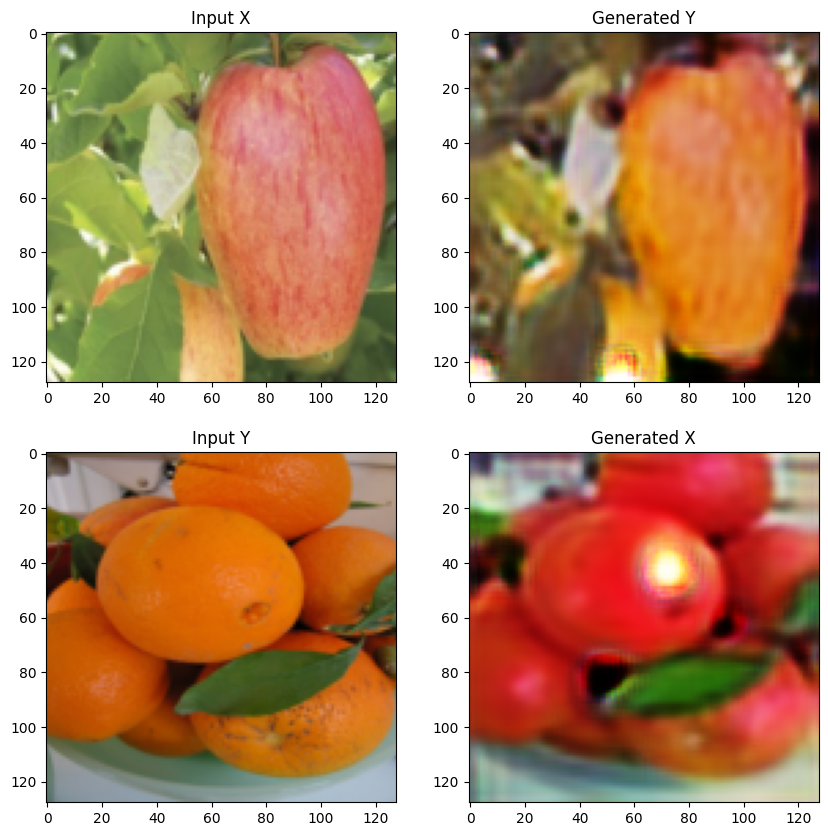

Saving checkpoint for epoch 30 at checkpoints/pytorch/apple2orange
Time taken for epoch 30 is 61.652374267578125 sec



In [ ]:
import time

training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / BATCH_SIZE)).astype(int)

for epoch in range(1, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):

        real_image_X = next(iter_train_image_X).to(device)
        real_image_Y = next(iter_train_image_Y).to(device)

        # ============================
        # Compute the discriminator loss
        # ============================
        # Generate fake images for discriminators

        fake_image_Y = generate_images(G_XtoY, real_image_X)
        fake_image_X = generate_images(G_YtoX, real_image_Y)
        Dx_real_pred = Dx(real_image_X)
        Dx_fake_pred = Dx(fake_image_X.detach())
        Dy_real_pred = Dy(real_image_Y)
        Dy_fake_pred = Dy(fake_image_Y.detach())



        # Compute the discriminator loss using the latest fake images

        Dx_loss = discriminator_loss(Dx_real_pred, Dx_fake_pred)
        Dy_loss = discriminator_loss(Dy_real_pred, Dy_fake_pred)

        # ============================
        # Update discriminators
        # ============================

        Dx_optimizer.zero_grad()
        Dx_loss.backward(retain_graph=True)  # Retain the graph for subsequent backward passes
        Dx_optimizer.step()

        Dy_optimizer.zero_grad()
        Dy_loss.backward(retain_graph=True)  # Retain the graph for subsequent backward passes
        Dy_optimizer.step()


        # Compute the generator loss using the latest fake images

        G_XtoY_loss = generator_loss(Dy(fake_image_Y))
        G_YtoX_loss = generator_loss(Dx(fake_image_X))


        # ============================
        # Compute the cycle consistency loss
        # ============================
        # Generate cycled images using the latest fake images

        cycled_image_X = generate_images(G_YtoX, fake_image_Y)
        cycled_image_Y = generate_images(G_XtoY, fake_image_X)


        # Compute the cycle consistency loss using the latest cycled images

        cycle_loss = (
            cycle_consistency_loss(real_image_X, cycled_image_X) +
            cycle_consistency_loss(real_image_Y, cycled_image_Y)
        )


        # ============================
        # Compute the identity loss
        # ============================
        # Generate identity images using the latest fake images

        identity_image_X = generate_images(G_YtoX, real_image_X)
        identity_image_Y = generate_images(G_XtoY, real_image_Y)


        # Compute the identity loss using the latest identity images

        computed_identity_loss = (
            identity_loss_function(real_image_X, identity_image_X) +
            identity_loss_function(real_image_Y, identity_image_Y)
        )


        # ============================
        # Combine all generator losses
        # ============================

        total_loss = G_XtoY_loss + G_YtoX_loss + cycle_loss + computed_identity_loss

        # ============================
        # Update generators
        # ============================

        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        total_loss.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()


        # Add losses

        G_XtoY_loss_mean += G_XtoY_loss.item()
        G_YtoX_loss_mean += G_YtoX_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()


        if step % 10 == 0:
            print ('.', end='')

    clear_output(wait=True)
    # ============================
    # Print loss values at the end of an epoch
    # ============================

    print(f"Epoch {epoch}/{EPOCHs}, G_XtoY Loss: {G_XtoY_loss_mean/training_steps:.4f}, "
      f"G_YtoX Loss: {G_YtoX_loss_mean/training_steps:.4f}, "
      f"Dx Loss: {Dx_loss_mean/training_steps:.4f}, "
      f"Dy Loss: {Dy_loss_mean/training_steps:.4f}")


    # ============================
    # Using consistent images (sample_X and sample_Y), plot the progress of the training using both generators
    # ============================

    generated_Y = generate_images(G_XtoY, sample_X.unsqueeze(0))
    generated_X = generate_images(G_YtoX, sample_Y.unsqueeze(0))

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow((sample_X.permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[0, 0].set_title("Input X")
    axs[0, 1].imshow((generated_Y.squeeze(0).detach().permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[0, 1].set_title("Generated Y")
    axs[1, 0].imshow((sample_Y.permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[1, 0].set_title("Input Y")
    axs[1, 1].imshow((generated_X.squeeze(0).detach().permute(1, 2, 0).cpu().numpy() + 1) / 2)
    axs[1, 1].set_title("Generated X")
    plt.show()



    # ============================
    # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch
    # ============================
    if epoch % SAVE_EVERY_N_EPOCH == 0:

        save_training_checkpoint(epoch)

        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

    gc.collect()